# 📈🏡 L'IA au service des agents immobiliers - ☀️ Silicon Valley

Contexte du projet

Vous êtes développeur AI dans une startup de la Silicon Valley qui fournit des services dans le domaine de l'investissement immowbilier. Les chargés de relation client ont mentionné que la demande a augmenté récemment et qu'il devient difficile de faire des estimations personnalisées. De ce fait, l'entreprise vous a confier d'automatiser cette tâche avec un modèle prédictif.

Pour cela, vous avez récupéré une base de données qui contient les prix médians des logements pour les districts de Californie issus du recensement de 1990 :

- longitude
- latitude
- housingMedianAge: Âge médian d'une maison dans un pâté de maisons ; un chiffre plus bas correspond à un bâtiment plus récent.
- totalRooms: Nombre total de chambres dans un bloc
- totalBedrooms: Nombre total de chambres dans un bloc
- population: Nombre total de personnes résidant dans un bloc
- households: Nombre total de ménages, c'est-à-dire un groupe de personnes résidant dans une unité d'habitation, pour un bloc
- medianIncome: Revenu médian des ménages dans un bloc de maisons (mesuré en dizaines de milliers de dollars US)
- medianHouseValue: Valeur médiane des maisons pour les ménages d'un bloc (mesurée en dollars US)
- oceanProximity: Situation de la maison par rapport à la mer

L'objectif est de créer un modèle avec vos données (train) pour prédire la valeur du prix médian des maisons par district / bloc (medianHouseValue). A la fin du projet, vous devez évaluer ce modèle avec les données (validation) que seul votre client dispose (le prof).

Pour mener à bien ce projet, vous devez faire les veilles suivantes au cours du projet :

- techniques de data cleaning : savoir traiter duplicates, missing data, outliers, scaling, balancing, encoding, discretizing, feature engineering
- inférence statistique : faire un analyse d'inférence avec la librairie statsmodels, savoir quantifier la signification statistique du modèle, identifier les cofounding factors, vérifier que les conditions d'inférence sont respectés
- Bonus: regularization, model KNN, model tuning


# 📊 Exploratory Data Analysis (EDA)

In [14]:
# imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopy
from geopy.geocoders import Nominatim

from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

#RegLog Kmeans
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.impute import KNNImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import hvplot.pandas
import pandas_profiling

In [15]:
# load dataset
df = pd.read_csv('dataset.csv')
df.head()

,Unnamed: 0,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,2072,-119.84,36.77,6.0,1853.0,473.0,1397.0,417.0,1.4817,72000.0,INLAND
1,10600,-117.80,33.68,8.0,2032.0,349.0,862.0,340.0,6.9133,274100.0,<1H OCEAN
2,2494,-120.19,36.60,25.0,875.0,214.0,931.0,214.0,1.5536,58300.0,INLAND
3,4284,-118.32,34.10,31.0,622.0,229.0,597.0,227.0,1.5284,200000.0,<1H OCEAN
4,16541,-121.23,37.79,21.0,1922.0,373.0,1130.0,372.0,4.0815,117900.0,INLAND


In [16]:
# basic informations about dataset (numbers of rows, columns)
df.shape

(16512, 11)

In [17]:
# check Dtype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          16512 non-null  int64  
 1   longitude           16512 non-null  float64
 2   latitude            16512 non-null  float64
 3   housing_median_age  16512 non-null  float64
 4   total_rooms         16512 non-null  float64
 5   total_bedrooms      16336 non-null  float64
 6   population          16512 non-null  float64
 7   households          16512 non-null  float64
 8   median_income       16512 non-null  float64
 9   median_house_value  16512 non-null  float64
 10  ocean_proximity     16512 non-null  object 
dtypes: float64(9), int64(1), object(1)
memory usage: 1.4+ MB


In [18]:
# check for zeros in all columns 
df[df == 0].count()

Unnamed: 0            1
longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [19]:
# count of missing values in dataset and where are they
df.isnull().sum()

Unnamed: 0              0
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        176
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [20]:
# max & min values on total_bedrooms
print(df['total_bedrooms'].max())
print(df['total_bedrooms'].min())

6445.0
2.0


In [21]:
# replace missing values on total_bedrooms with KNN
knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
df['total_bedrooms'] = knn_imputer.fit_transform(df[['total_bedrooms']])

In [22]:
# number of missing values now on total_bedrooms
df['total_bedrooms'].isnull().sum()

0

In [23]:
# remove unused column Unnamed: 0
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [24]:
# see values on ocean_proximity
df['ocean_proximity'].value_counts()

<1H OCEAN     7312
INLAND        5235
NEAR OCEAN    2140
NEAR BAY      1821
ISLAND           4
Name: ocean_proximity, dtype: int64

In [25]:
# convert ocean_priximity "object" in "float"
# df["ocean_proximity"] = df['ocean_proximity'].astype('float')

In [26]:
# encoding ocean_proximity
clean_df = pd.get_dummies(df, columns=['ocean_proximity'], prefix=["place"])
clean_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,place_<1H OCEAN,place_INLAND,place_ISLAND,place_NEAR BAY,place_NEAR OCEAN
0,-119.84,36.77,6.0,1853.0,473.0,1397.0,417.0,1.4817,72000.0,0,1,0,0,0
1,-117.80,33.68,8.0,2032.0,349.0,862.0,340.0,6.9133,274100.0,1,0,0,0,0
2,-120.19,36.60,25.0,875.0,214.0,931.0,214.0,1.5536,58300.0,0,1,0,0,0
3,-118.32,34.10,31.0,622.0,229.0,597.0,227.0,1.5284,200000.0,1,0,0,0,0
4,-121.23,37.79,21.0,1922.0,373.0,1130.0,372.0,4.0815,117900.0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,-121.90,39.59,20.0,1465.0,278.0,745.0,250.0,3.0625,93800.0,0,1,0,0,0
16508,-122.25,38.11,49.0,2365.0,504.0,1131.0,458.0,2.6133,103100.0,0,0,0,1,0
16509,-121.22,38.92,19.0,2531.0,461.0,1206.0,429.0,4.4958,192600.0,0,1,0,0,0
16510,-118.14,34.16,39.0,2776.0,840.0,2546.0,773.0,2.5750,153500.0,1,0,0,0,0


In [27]:
# convert ocean_priximity in "float"
clean_df['place_<1H OCEAN'] = clean_df['place_<1H OCEAN'].astype('float')
clean_df['place_INLAND'] = clean_df['place_INLAND'].astype('float')
clean_df['place_NEAR BAY'] = clean_df['place_NEAR BAY'].astype('float')
clean_df['place_NEAR OCEAN'] = clean_df['place_NEAR OCEAN'].astype('float')
clean_df['place_ISLAND'] = clean_df['place_ISLAND'].astype('float')

# Checking the target variable

In [14]:
clean_df['median_house_value'].describe()

count     16512.000000
mean     206509.251453
std      115225.957661
min       14999.000000
25%      119400.000000
50%      179300.000000
75%      264500.000000
max      500001.000000
Name: median_house_value, dtype: float64

In [28]:
# max & min value on median_house_value
print(clean_df['median_house_value'].max())
print(clean_df['median_house_value'].min())

500001.0
14999.0


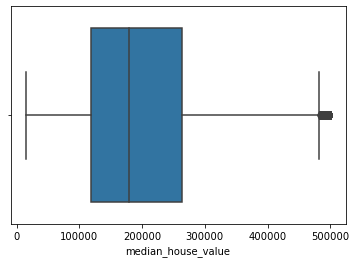

In [29]:
# boxplot
sns.boxplot(clean_df['median_house_value'])
plt.show()

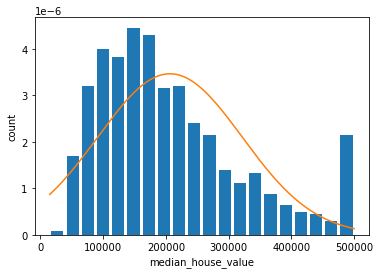

In [30]:
# plot bell curve with histogram
plt.hist(clean_df.median_house_value, bins=20, rwidth=0.8, density=True)
plt.xlabel('median_house_value')
plt.ylabel('count')

rng = np.arange(clean_df.median_house_value.min(), clean_df.median_house_value.max(), 0.1)
plt.plot(rng, norm.pdf(rng,clean_df.median_house_value.mean(),clean_df.median_house_value.std()))

<AxesSubplot:>

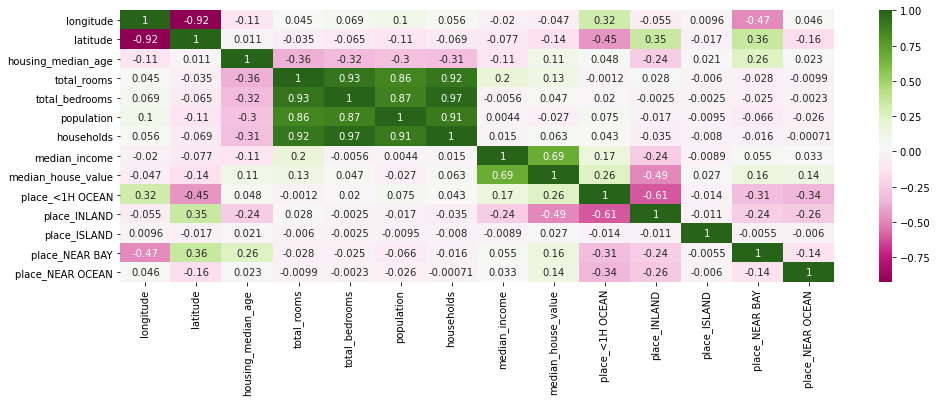

In [35]:
# correlation matrix
plt.figure(figsize = (16,5))
sns.heatmap(corr, annot=True, cmap="PiYG")

In [34]:
# most correlated features 
corr["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.689659
place_<1H OCEAN       0.259012
place_NEAR BAY        0.159640
place_NEAR OCEAN      0.142921
total_rooms           0.133218
housing_median_age    0.108626
households            0.063245
total_bedrooms        0.047240
place_ISLAND          0.026636
population           -0.027441
longitude            -0.046754
latitude             -0.143970
place_INLAND         -0.488003
Name: median_house_value, dtype: float64

In [36]:
# most correlated feature
corr = clean_df.corr()
top_corr_features = corr.index[abs(corr['median_house_value'])>0.5]
top_corr_features

Index(['median_income', 'median_house_value'], dtype='object')

In [22]:
# import hvplot et scatter median_income with median_house_value
clean_df.hvplot.scatter(x='median_income', y='median_house_value')

:Scatter   [median_income]   (median_house_value)

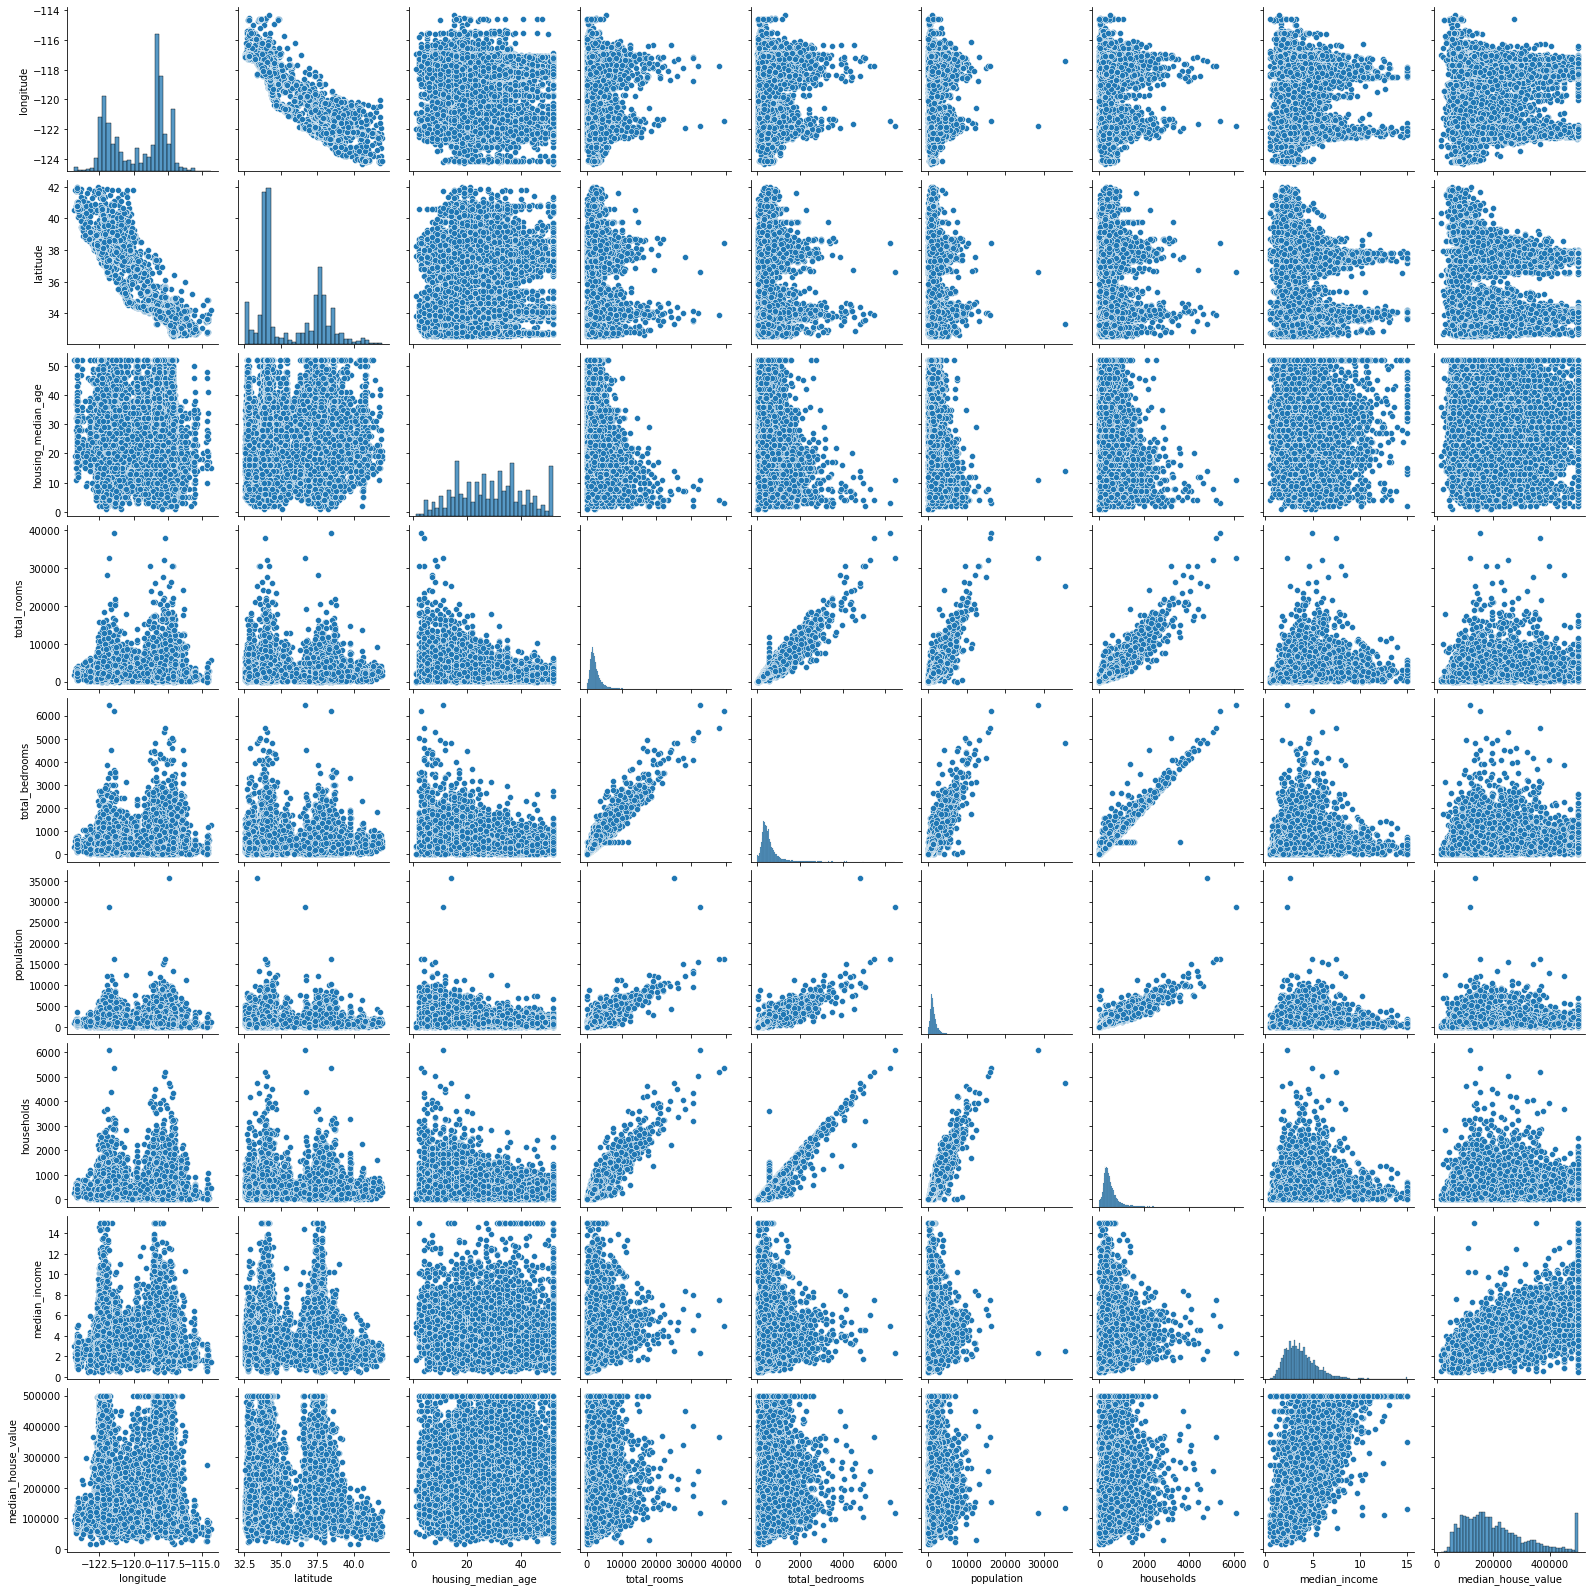

In [41]:
# pairplot
sns.pairplot(df)

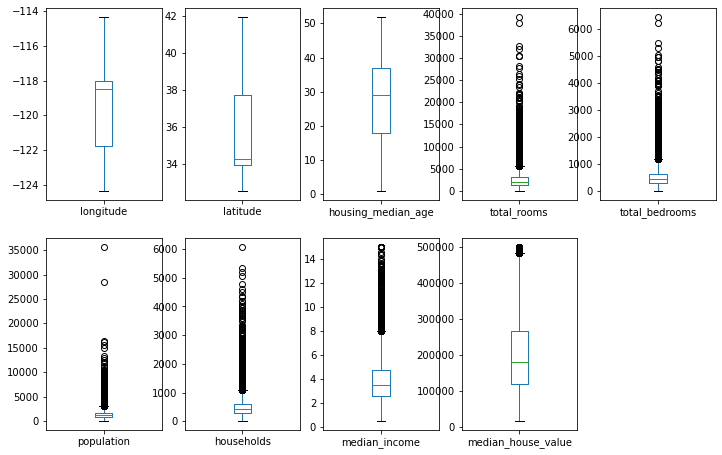

In [42]:
#individuel plot
df.plot(kind='box', subplots=True, layout=(3, 5), figsize=(12, 12));